In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define evaluation functions

def MAPE(v, v_, axis=None):
    mask = v != 0  # Ignore samples where true value is 0
    if np.any(mask):
        mape = (np.abs(v_[mask] - v[mask]) / np.abs(v[mask])).astype(np.float64)
        mape = np.where(mape > 5, 5, mape)
        return np.mean(mape, axis)
    else:
        return np.nan  # Or some default if all are zero

def RMSE(v, v_, axis=None):
    return np.sqrt(np.mean((v_ - v) ** 2, axis)).astype(np.float64)

def MAE(v, v_, axis=None):
    return np.mean(np.abs(v_ - v), axis).astype(np.float64)

Daily State

In [42]:
# Auto-evaluate methods with automatic P/H/offset alignment
import numpy as np, pandas as pd

# Load original raw data (drop header row of IDs)
valid_raw = pd.read_csv('../../baselines_imputation/MTGNN/raw/confirmed_state_valid.csv', header=None).iloc[1:].values
test_raw  = pd.read_csv('../../baselines_imputation/MTGNN/raw/confirmed_state_test.csv', header=None).iloc[1:].values

# Function to find best P, H, offset by minimizing MSE between method GT and original
def find_best_alignment(gt_csv_path, raw_array, P_range=[10,12,14], H_range=[10,12,14], offset_range=range(-5,6)):
    gt = np.loadtxt(gt_csv_path, delimiter=',')
    num_samples = gt.shape[0]
    seq_len = raw_array.shape[0]
    best_mse = float('inf')
    best_P, best_H, best_offset = None, None, None
    for P in P_range:
        for H in H_range:
            N_eff = num_samples + P + H - 1
            if N_eff > seq_len:
                continue
            for offset in offset_range:
                indices = P + np.arange(num_samples) + offset
                indices = np.clip(indices, 0, seq_len - 1)
                orig = raw_array[indices]
                mse = np.mean((gt - orig)**2)
                if mse < best_mse:
                    best_mse = mse
                    best_P = P
                    best_H = H
                    best_offset = offset
    return best_P, best_H, best_offset, best_mse

# Methods to evaluate (add more if they have GT CSVs)
methods = ['stemgnn', 'mtgnn','baseline']

for method in methods:
    print(f"\nEvaluating {method.upper()}...")
    
    # Define GT CSV path for alignment (use step1 for multi-step methods)
    if method == 'mtgnn':
        gt_path_val = '../../baselines_imputation/MTGNN/predictions/daily/val_step_1_ground_truth.csv'
        gt_path_test = '../../baselines_imputation/MTGNN/predictions/daily/test_step_1_ground_truth.csv'
        is_multi_step = True
        steps = 7
        pred_dir_val = '../../baselines_imputation/MTGNN/predictions/daily/val_step_{}_predictions.csv'
        pred_dir_test = '../../baselines_imputation/MTGNN/predictions/daily/test_step_{}_predictions.csv'
    elif method == 'stemgnn':
        gt_path_val = '../../baselines_imputation/StemGNN/output/confirmed_state/train/val_step_1_ground_truth.csv'
        gt_path_test = '../../baselines_imputation/StemGNN/output/confirmed_state/test/test_step_1_ground_truth.csv'
        is_multi_step = True
        steps = 7
        pred_dir_val = '../../baselines_imputation/StemGNN/output/confirmed_state/train/val_step_{}_predictions.csv'
        pred_dir_test = '../../baselines_imputation/StemGNN/output/confirmed_state/test/test_step_{}_predictions.csv'
    elif method == 'baseline':
        # Baseline uses raw data directly, no GT CSV, use step1 GT as reference for alignment
        gt_path_val = '../../baselines_imputation/MTGNN/predictions/daily/val_step_1_ground_truth.csv'  # Use MTGNN step1 GT for alignment
        gt_path_test = '../../baselines_imputation/MTGNN/predictions/daily/test_step_1_ground_truth.csv'
        is_multi_step = True
        steps = 7
        # No pred_dir, use raw directly
    else:
        # For single-step methods like stemgnn
        gt_path_val = f'../../baselines_imputation/{method.upper()}/predictions/daily/val_ground_truth.csv'
        gt_path_test = f'../../baselines_imputation/{method.upper()}/predictions/daily/test_ground_truth.csv'
        is_multi_step = False
        steps = 1
        pred_dir_val = f'../../baselines_imputation/{method.upper()}/predictions/daily/val_predictions.csv'
        pred_dir_test = f'../../baselines_imputation/{method.upper()}/predictions/daily/test_predictions.csv'
    
    # Find best alignment for val and test (use val for selection)
    best_P, best_H, best_offset, best_mse = find_best_alignment(gt_path_val, valid_raw)
    print(f"Best alignment: P={best_P}, H={best_H}, offset={best_offset}, MSE={best_mse:.2f}")
    
    # Now evaluate with best params
    if is_multi_step:
        for k in range(1, steps+1):
            try:
                if method == 'baseline':
                    # For baseline, pred is raw shifted by k days
                    pred_val = valid_raw[:-k]  # Use t-k to predict t
                    orig_val_full = valid_raw[k:]  # Target is t
                    min_len_val = min(len(pred_val), len(orig_val_full))
                    pred_val = pred_val[:min_len_val]
                    orig_val = orig_val_full[:min_len_val]
                    
                    pred_test = test_raw[:-k]
                    orig_test_full = test_raw[k:]
                    min_len_test = min(len(pred_test), len(orig_test_full))
                    pred_test = pred_test[:min_len_test]
                    orig_test = orig_test_full[:min_len_test]
                else:
                    pred_val = np.loadtxt(pred_dir_val.format(k), delimiter=',')
                    pred_test = np.loadtxt(pred_dir_test.format(k), delimiter=',')
                    
                    # Align original targets
                    L_val = pred_val.shape[0]
                    L_test = pred_test.shape[0]
                    indices_val = best_P + np.arange(L_val) + (k - 1) + best_offset
                    indices_val = np.clip(indices_val, 0, valid_raw.shape[0] - 1)
                    orig_val = valid_raw[indices_val]
                    
                    indices_test = best_P + np.arange(L_test) + (k - 1) + best_offset
                    indices_test = np.clip(indices_test, 0, test_raw.shape[0] - 1)
                    orig_test = test_raw[indices_test]
                
                # Metrics
                mape_val = MAPE(orig_val, pred_val)
                rmse_val = RMSE(orig_val, pred_val)
                mae_val = MAE(orig_val, pred_val)
                mape_test = MAPE(orig_test, pred_test)
                rmse_test = RMSE(orig_test, pred_test)
                mae_test = MAE(orig_test, pred_test)
                
                print(f"Step {k} | Valid MAPE {mape_val:.4f} RMSE {rmse_val:.2f} MAE {mae_val:.2f} | Test MAPE {mape_test:.4f} RMSE {rmse_test:.2f} MAE {mae_test:.2f}")
            except Exception as e:
                print(f"Error evaluating {method} step {k}: {e}")
    else:
        # Single-step evaluation
        try:
            pred_val = np.loadtxt(pred_dir_val, delimiter=',')
            pred_test = np.loadtxt(pred_dir_test, delimiter=',')
            
            L_val = pred_val.shape[0]
            L_test = pred_test.shape[0]
            indices_val = best_P + np.arange(L_val) + best_offset
            indices_val = np.clip(indices_val, 0, valid_raw.shape[0] - 1)
            orig_val = valid_raw[indices_val]
            
            indices_test = best_P + np.arange(L_test) + best_offset
            indices_test = np.clip(indices_test, 0, test_raw.shape[0] - 1)
            orig_test = test_raw[indices_test]
            
            mape_val = MAPE(orig_val, pred_val)
            rmse_val = RMSE(orig_val, pred_val)
            mae_val = MAE(orig_val, pred_val)
            mape_test = MAPE(orig_test, pred_test)
            rmse_test = RMSE(orig_test, pred_test)
            mae_test = MAE(orig_test, pred_test)
            
            print(f"Valid MAPE {mape_val:.4f} RMSE {rmse_val:.2f} MAE {mae_val:.2f} | Test MAPE {mape_test:.4f} RMSE {rmse_test:.2f} MAE {mae_test:.2f}")
        except Exception as e:
            print(f"Error evaluating {method}: {e}")


Evaluating STEMGNN...
Best alignment: P=10, H=10, offset=2, MSE=0.00
Step 1 | Valid MAPE 0.9516 RMSE 3986.33 MAE 2106.12 | Test MAPE 1.0676 RMSE 2930.82 MAE 1405.92
Step 2 | Valid MAPE 1.2755 RMSE 4359.67 MAE 2564.52 | Test MAPE 1.8843 RMSE 4513.43 MAE 2914.68
Step 3 | Valid MAPE 1.2843 RMSE 4420.80 MAE 2587.00 | Test MAPE 1.6147 RMSE 4054.01 MAE 2464.33
Step 4 | Valid MAPE 1.4421 RMSE 4965.82 MAE 3052.76 | Test MAPE 1.9031 RMSE 4722.15 MAE 3013.20
Step 5 | Valid MAPE 1.1324 RMSE 4008.22 MAE 2362.69 | Test MAPE 1.5162 RMSE 3862.28 MAE 2286.82
Step 6 | Valid MAPE 1.3076 RMSE 4351.45 MAE 2538.59 | Test MAPE 1.7747 RMSE 4419.07 MAE 2773.10
Step 7 | Valid MAPE 1.1469 RMSE 4129.71 MAE 2317.08 | Test MAPE 1.3762 RMSE 3639.32 MAE 2057.77

Evaluating MTGNN...
Best alignment: P=10, H=10, offset=3, MSE=0.00
Step 1 | Valid MAPE 0.7049 RMSE 2891.56 MAE 1332.74 | Test MAPE 0.7681 RMSE 2644.56 MAE 1013.41
Step 2 | Valid MAPE 1.9424 RMSE 4625.09 MAE 2757.12 | Test MAPE 2.2407 RMSE 3564.70 MAE 2545.5

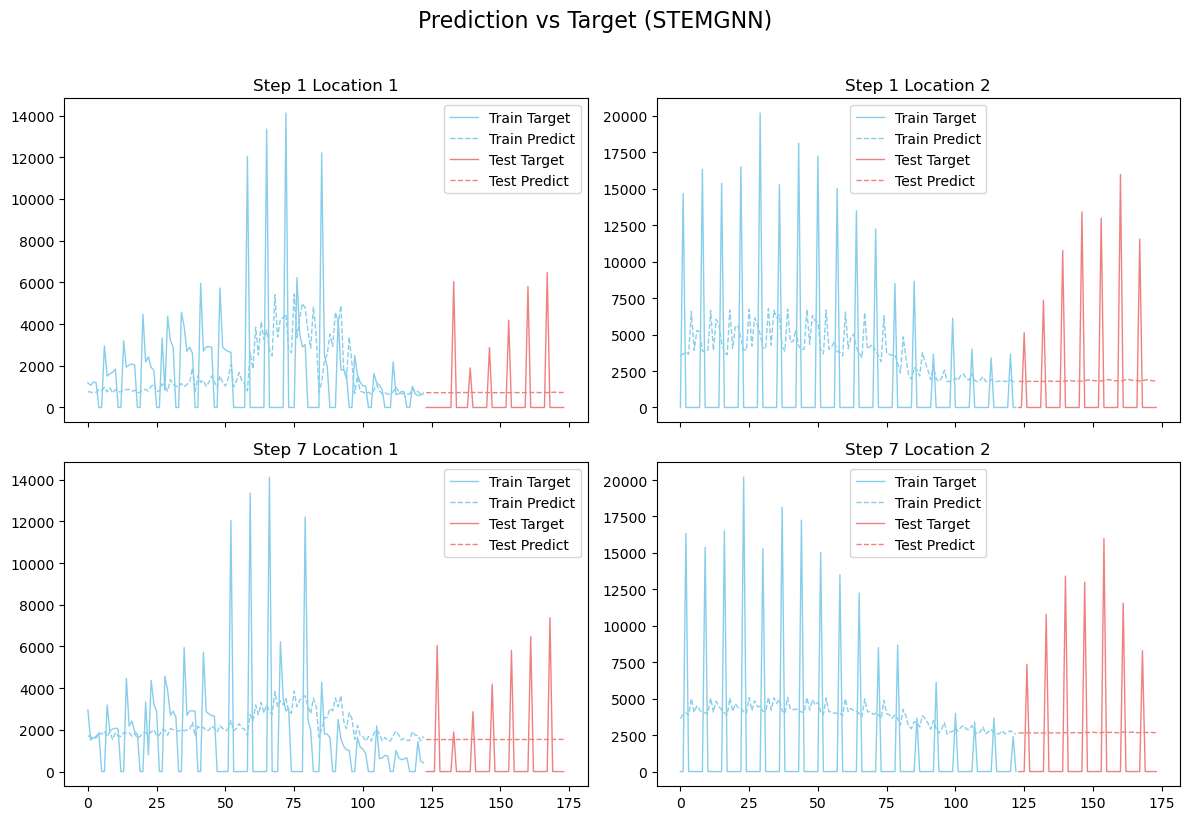

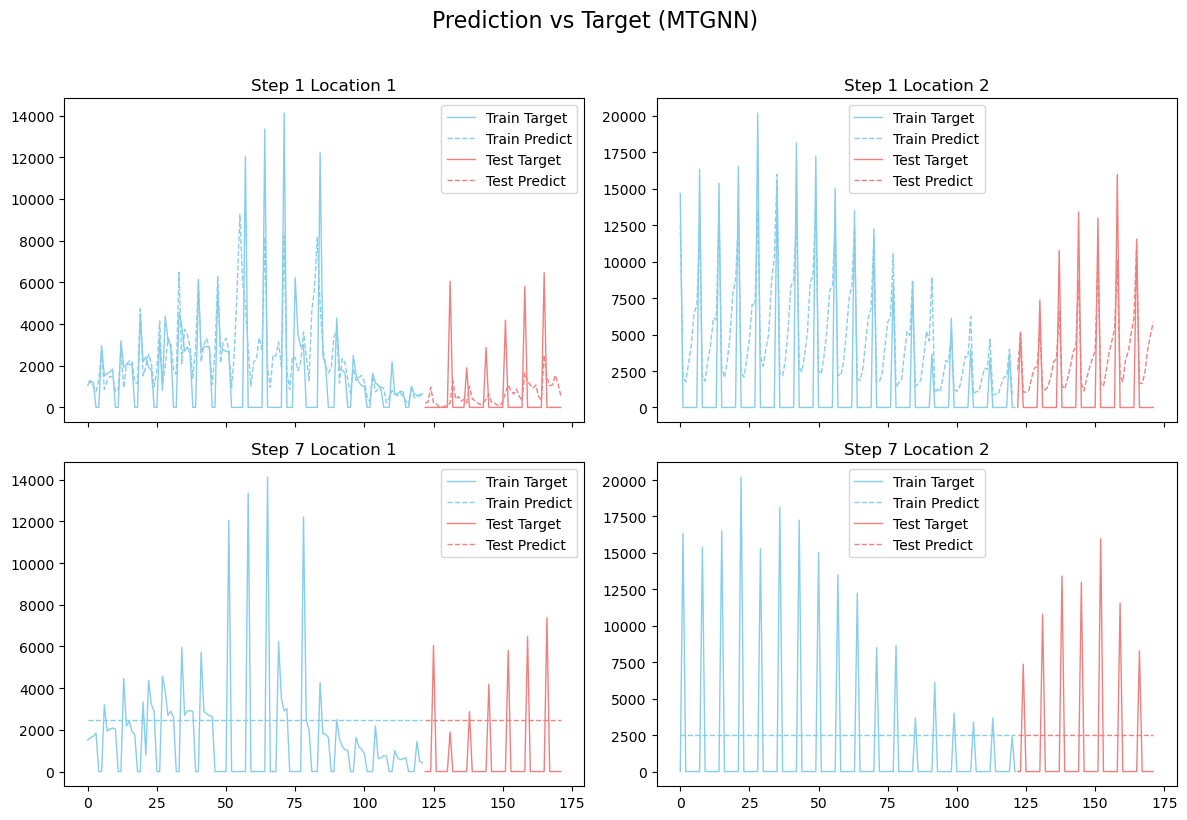

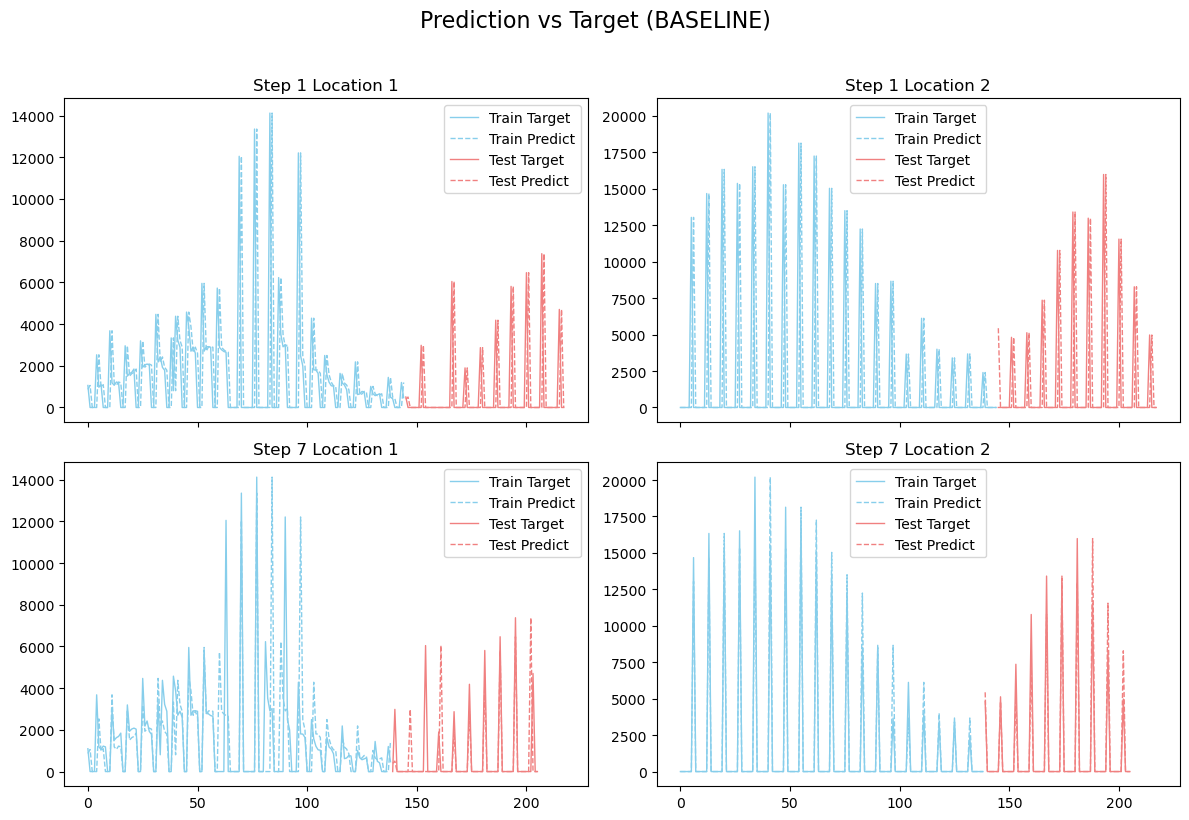

In [41]:
# Plot predictions for each method in a 2x2 grid (step 1/7, location 1/2)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load original raw data for baseline
valid_raw = pd.read_csv('/shares/mxq6904/yilongchen/baselines_imputation/MTGNN/raw/confirmed_state_valid.csv', header=None).iloc[1:].values
test_raw  = pd.read_csv('/shares/mxq6904/yilongchen/baselines_imputation/MTGNN/raw/confirmed_state_test.csv', header=None).iloc[1:].values

methods = ['stemgnn', 'mtgnn', 'baseline']

for method in methods:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
    axes = axes.flatten()
    idx = 0
    for step in [1, 7]:
        try:
            if method == 'stemgnn':
                predict_train = np.loadtxt(f'../../baselines_imputation/StemGNN/output/confirmed_state/train/val_step_{step}_predictions.csv', delimiter=',')
                target_train = np.loadtxt(f'../../baselines_imputation/StemGNN/output/confirmed_state/train/val_step_{step}_ground_truth.csv', delimiter=',')
                predict_test = np.loadtxt(f'../../baselines_imputation/StemGNN/output/confirmed_state/test/test_step_{step}_predictions.csv', delimiter=',')
                target_test = np.loadtxt(f'../../baselines_imputation/StemGNN/output/confirmed_state/test/test_step_{step}_ground_truth.csv', delimiter=',')
            elif method == 'mtgnn':
                predict_train = np.loadtxt(f'../../baselines_imputation/MTGNN/predictions/daily/val_step_{step}_predictions.csv', delimiter=',')
                target_train = np.loadtxt(f'../../baselines_imputation/MTGNN/predictions/daily/val_step_{step}_ground_truth.csv', delimiter=',')
                predict_test = np.loadtxt(f'../../baselines_imputation/MTGNN/predictions/daily/test_step_{step}_predictions.csv', delimiter=',')
                target_test = np.loadtxt(f'../../baselines_imputation/MTGNN/predictions/daily/test_step_{step}_ground_truth.csv', delimiter=',')
            elif method == 'baseline':
                # Baseline: use k days ago as prediction
                predict_train = valid_raw[:-step]  # Use t-step to predict t
                target_train = valid_raw[step:]    # Target is t
                min_len_train = min(len(predict_train), len(target_train))
                predict_train = predict_train[:min_len_train]
                target_train = target_train[:min_len_train]
                
                predict_test = test_raw[:-step]
                target_test = test_raw[step:]
                min_len_test = min(len(predict_test), len(target_test))
                predict_test = predict_test[:min_len_test]
                target_test = target_test[:min_len_test]

            for loc in range(2):
                ax = axes[idx]
                # Plot train data
                ax.plot(range(len(target_train)), target_train[:, loc], label='Train Target', linewidth=1, color='skyblue')
                ax.plot(range(len(predict_train)), predict_train[:, loc], label='Train Predict', linewidth=1, linestyle='--', color='skyblue')
                # Plot test data
                start_test = len(target_train)
                ax.plot(range(start_test, start_test + len(target_test)), target_test[:, loc], label='Test Target', linewidth=1, color='lightcoral')
                ax.plot(range(start_test, start_test + len(predict_test)), predict_test[:, loc], label='Test Predict', linewidth=1, linestyle='--', color='lightcoral')
                ax.set_title(f'Step {step} Location {loc+1}')
                ax.legend()
                idx += 1

        except Exception as e:
            print(f"Error plotting {method} step {step}: {e}. Skipping.")
            idx += 2  # Skip both locations for this step

    fig.suptitle(f'Prediction vs Target ({method.upper()})', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()